In [2]:
#Bộ dữ liệu đang được sử dụng cho Dự báo lưu lượng truy cập trang web.
#được thu thập từ dữ liệu lưu lượng truy cập hàng ngày của thecleverprogrammer.com. 
#Nó chứa dữ liệu về dữ liệu lưu lượng truy cập hàng ngày từ tháng 6 năm 2021 đến tháng 6 năm 2022.

import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

data = pd.read_csv("Thecleverprogrammer-copy.csv")
print(data.head())

         Date  Views
0  01/06/2021   7831
1  02/06/2021   7798
2  03/06/2021   7401
3  04/06/2021   7054
4  05/06/2021   7973


In [3]:
#Tập dữ liệu chứa hai cột, ngày và lưu lượng truy cập. 
#Chuyển đổi cột Ngày thành kiểu dữ liệu Ngày giờ.
data["Date"] = pd.to_datetime(data["Date"], 
                              format="%d/%m/%Y")
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    330 non-null    datetime64[ns]
 1   Views   330 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 5.3 KB
None


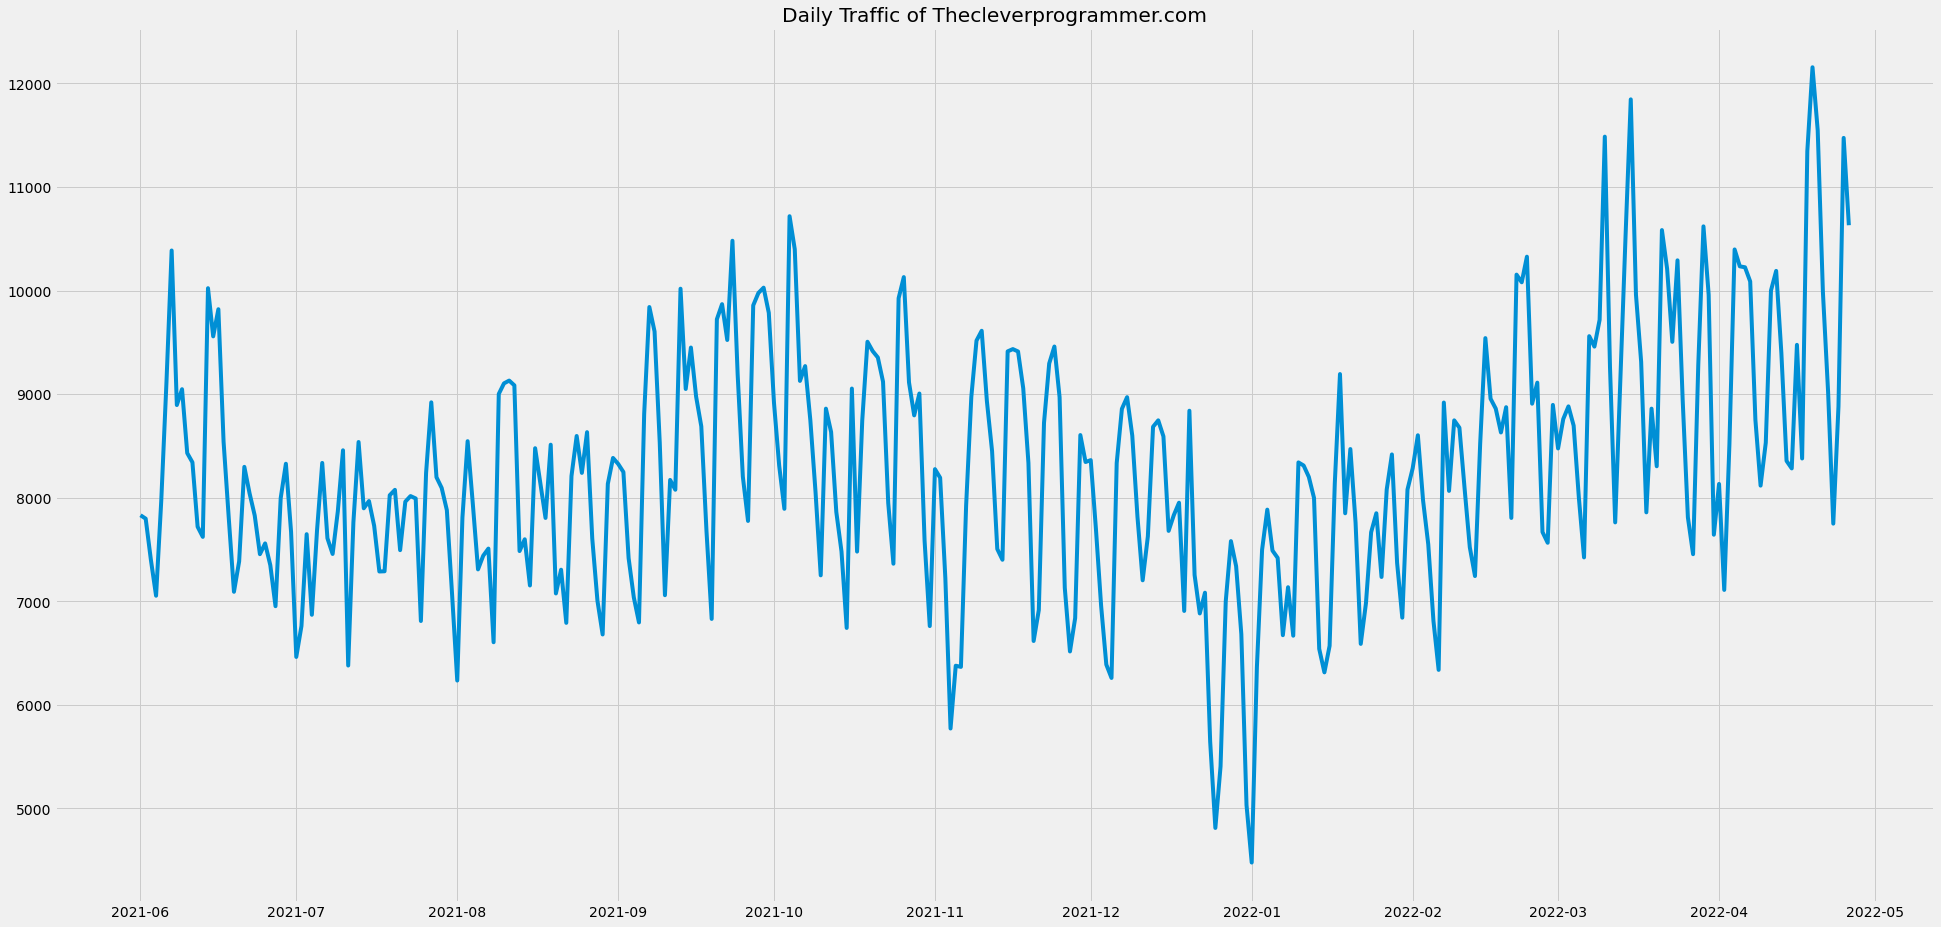

In [4]:
#Cột Ngày giờ ban đầu là một đối tượng, vì vậy đã chuyển đổi nó thành cột Ngày giờ.
#Xuất ra lưu lượng truy cập hàng ngày của trang web:

plt.style.use('fivethirtyeight')

#Kích thước biểu đồ
plt.figure(figsize=(30, 15))

plt.plot(data["Date"], data["Views"]) ##Cột dọc là số lượng truy cập, cột ngang là khoảng thời gian từ 06/2021 đến 04/2022

#Tiêu đề
plt.title("Daily Traffic of Thecleverprogrammer.com")

#Xuất ra biểu đồ
plt.show()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

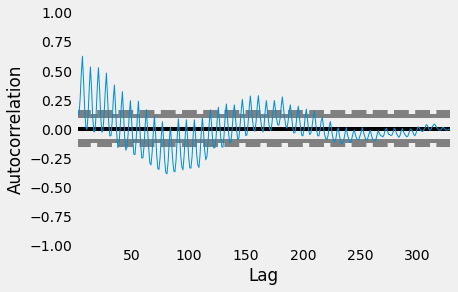

In [5]:
# Sử dụng mô hình ARIMA theo mùa (SARIMA) để dự báo lưu lượng truy cập trên trang web. 
# Trước khi sử dụng mô hình SARIMA, cần tìm các giá trị p, d và q.
# Vì dữ liệu không cố định nên giá trị của d là 1. 
# Để tìm giá trị của p và q, ta sử dụng biểu đồ tự tương quan và tự tương quan một phần:

pd.plotting.autocorrelation_plot(data["Views"], linewidth=1)

<Figure size 432x288 with 0 Axes>

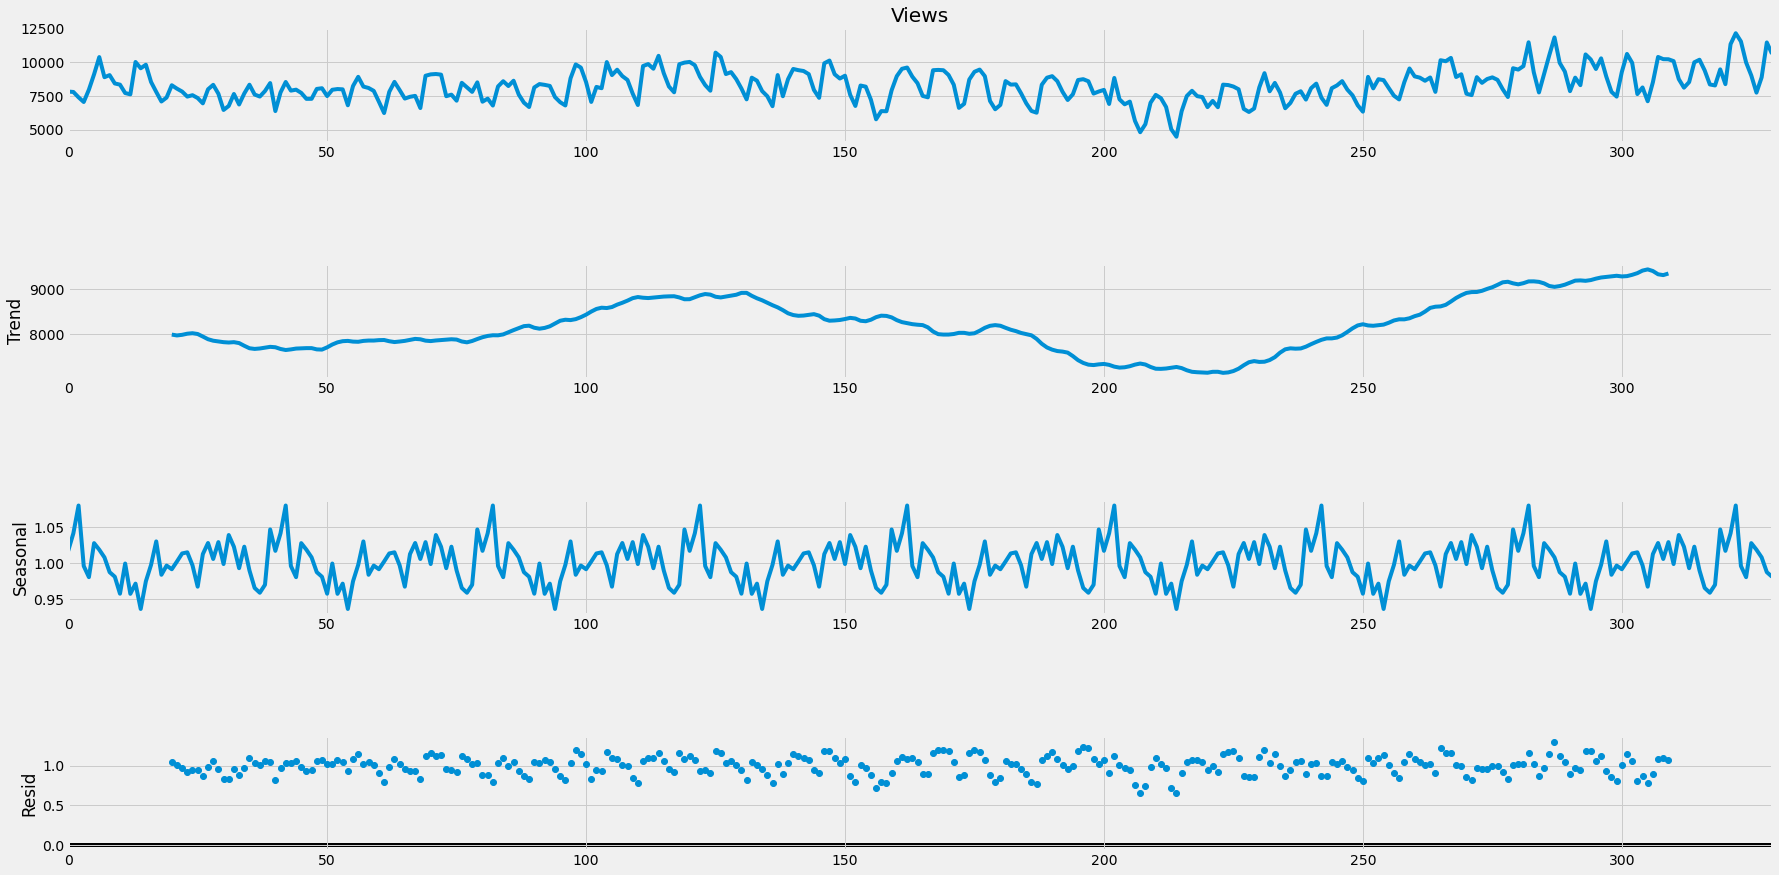

In [6]:
# Dữ liệu lưu lượng truy cập trang web của chúng tôi là theo mùa
# Vì lưu lượng truy cập trên trang web tăng vào các ngày trong tuần 
# và giảm vào các ngày cuối tuần. 
# Cần biết liệu tập dữ liệu có theo mùa hay không 
# trong khi giải quyết vấn đề về Dự báo chuỗi thời gian

result = seasonal_decompose(data["Views"], 
                            model='multiplicative', 
                            period = 40)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(30, 15)

In [7]:
# Augmented Dickey-Fuller test 
from statsmodels.tsa.stattools import adfuller
result = adfuller(data['Views'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.881032
p-value: 0.341036
Critical Values:
	1%: -3.451
	5%: -2.871
	10%: -2.572


<AxesSubplot:>

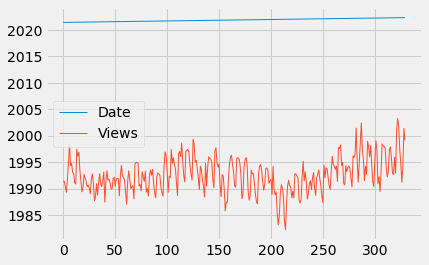

In [8]:
# Ở đây chúng ta có thể thấy rằng giá trị p lớn hơn 0,05
# điều này có nghĩa là giả thuyết rỗng của chúng ta sẽ bị bác bỏ 
# Và chúng ta sẽ coi chuỗi này là không cố định
# Tạo một biểu đồ dữ liệu này
data.plot(linewidth=1)

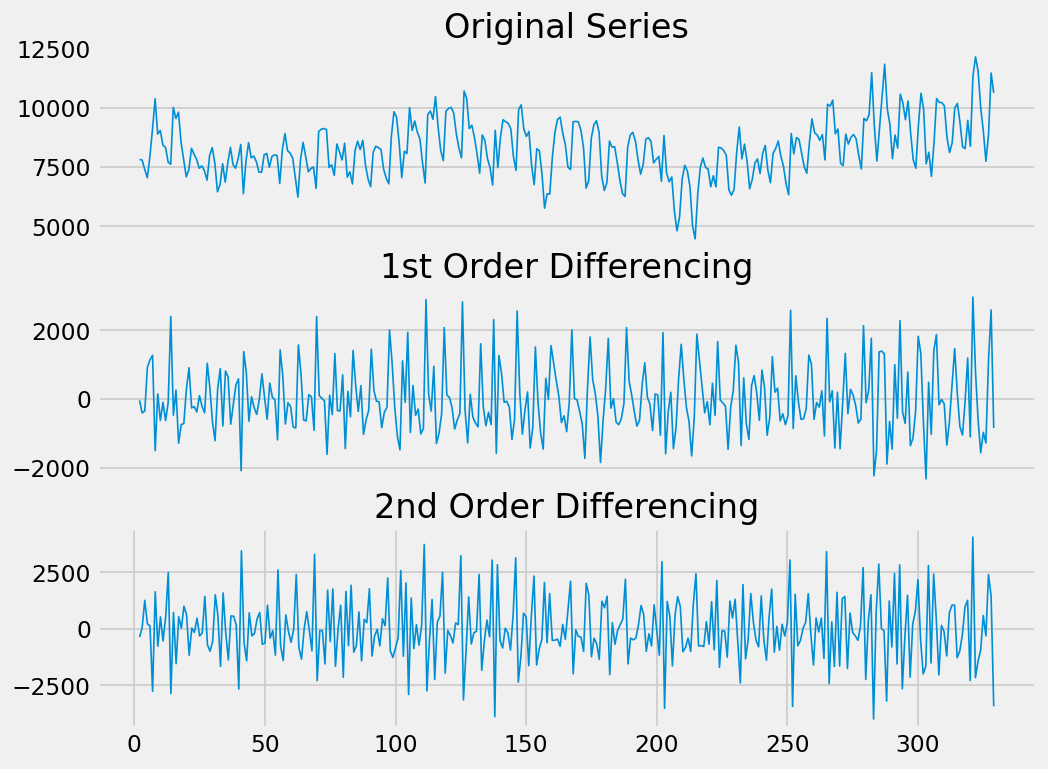

In [9]:
# Không có phương pháp nào có thể cho chúng ta biết giá trị của d bao nhiêu sẽ là tối ưu. 
# Tuy nhiên, giá trị của sự khác biệt có thể tối ưu cho đến 2
# vì vậy chúng ta sẽ thử chuỗi thời gian của mình cho cả hai. 
# Pandas cung cấp tùy chọn khác biệt này.

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
 
# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3, linewidth=1)
ax1.plot(data.Views, linewidth=1); ax1.set_title('Original Series'); 
ax1.axes.xaxis.set_visible(False)

# 1st Differencing
ax2.plot(data.Views.diff(), linewidth=1); 
ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)

# 2nd Differencing
ax3.plot(data.Views.diff().diff(), linewidth=1); ax3.set_title('2nd Order Differencing')
plt.show()

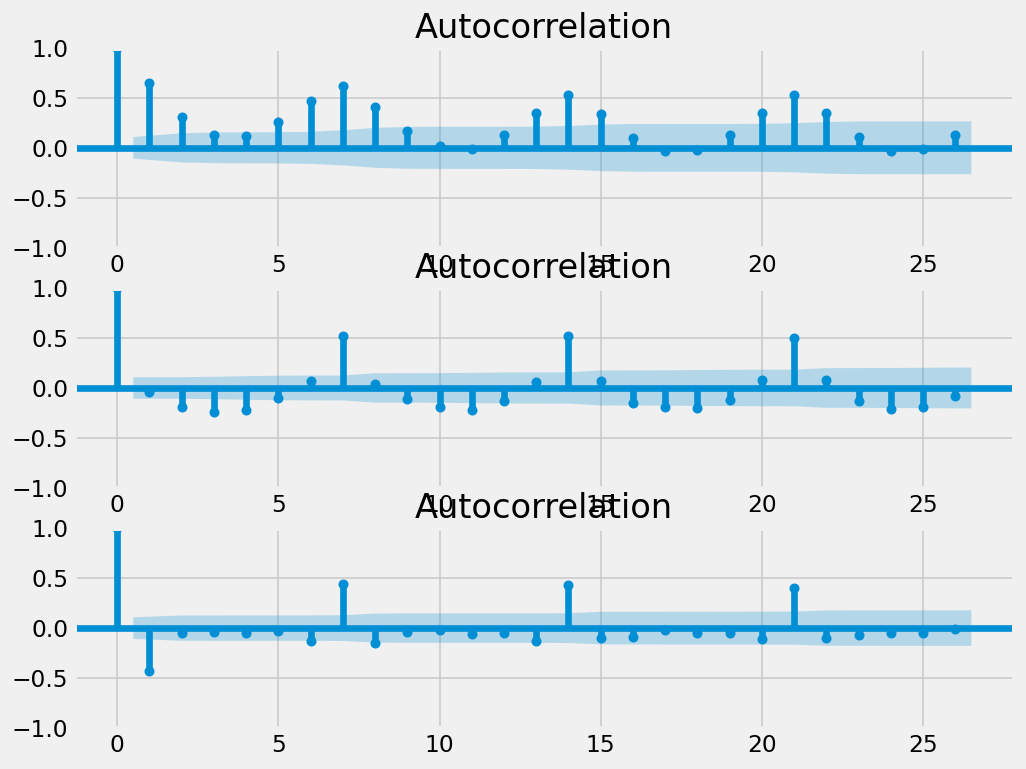

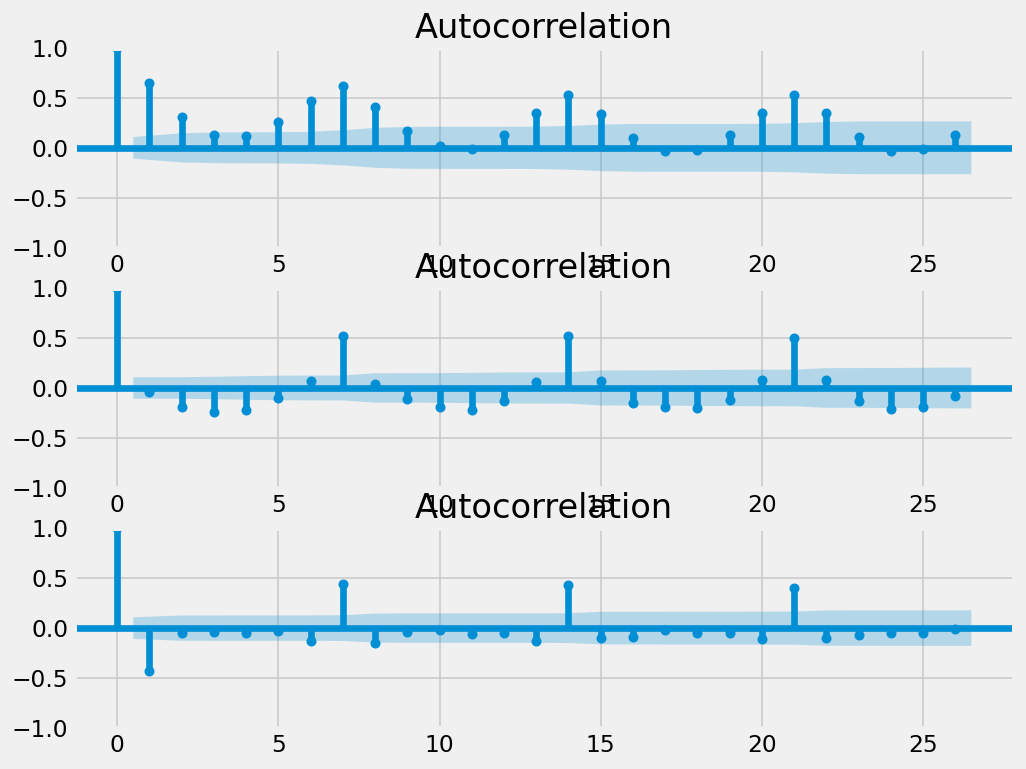

In [10]:
# Ở trên chúng ta có thể thấy chuỗi thời gian đã dừng
# Một điều đáng chú ý ở đây là trong sự khác biệt bậc nhất, 
# ta có ít sự nhiễu loạn hơn trong dữ liệu sau bậc 1, sự nhiễu loạn tăng lên.
# Vì vậy, ta có thể chọn chênh lệch thứ tự đầu tiên cho mô hình của mình.
# Chúng ta cũng có thể xác minh điều này bằng cách sử dụng biểu đồ tự tương quan.

from statsmodels.graphics.tsaplots import plot_acf
fig, (ax1, ax2, ax3) = plt.subplots(3)
plot_acf(data.Views, ax=ax1)
plot_acf(data.Views.diff().dropna(), ax=ax2)
plot_acf(data.Views.diff().diff().dropna(), ax=ax3)

In [11]:
# Ở đây chúng ta có thể thấy rằng trong sai khác bậc hai, 
# độ trễ tức thời đã chuyển sang mặt tiêu cực, 
# thể hiện rằng ở bậc hai, chuỗi đã vượt qua sai khác.

In [12]:
# Trong phần trên, chúng ta đã xác định được giá trị tối ưu của d. 
# Bây giờ trong phần này, chúng ta sẽ tìm giá trị tối ưu của p 
# là số lượng các số hạng tự hồi quy của chúng ta. 
# Chúng ta có thể tìm thấy giá trị này bằng cách kiểm tra biểu đồ PACF. 

# Biểu đồ hàm tự tương quan từng phần có thể được sử dụng 
# để vẽ mối tương quan giữa chuỗi thời gian
# và độ trễ của nó trong khi đóng góp từ độ trễ trung gian có thể được bỏ qua. 
# Biểu đồ này sẽ cho chúng ta biết về độ trễ không cần thiết trong phần tự hồi quy.

# Mối tương quan đáng kể trong chuỗi thời gian cố định 
# có thể được biểu thị bằng cách thêm các thuật ngữ hồi quy tự động. 
# Sử dụng biểu đồ PACF, chúng ta có thể lấy thứ tự của các thuật ngữ AR bằng với độ trễ
# bằng với độ trễ có thể vượt qua giới hạn ý nghĩa.

C:\Anaconda\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


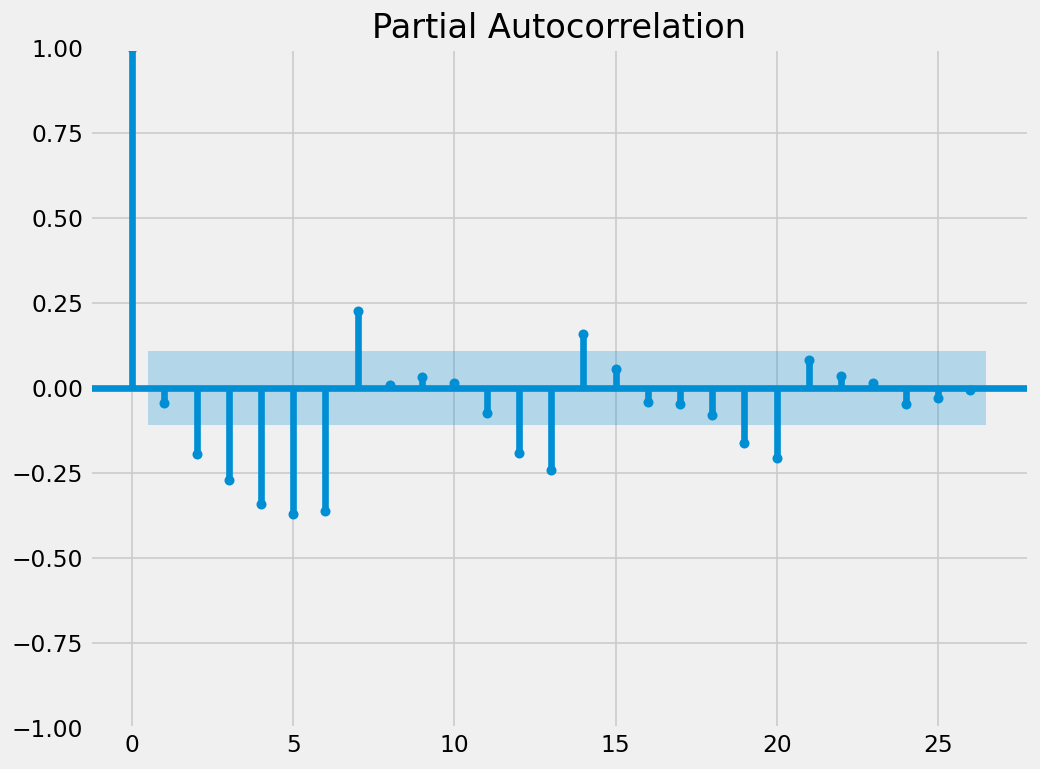

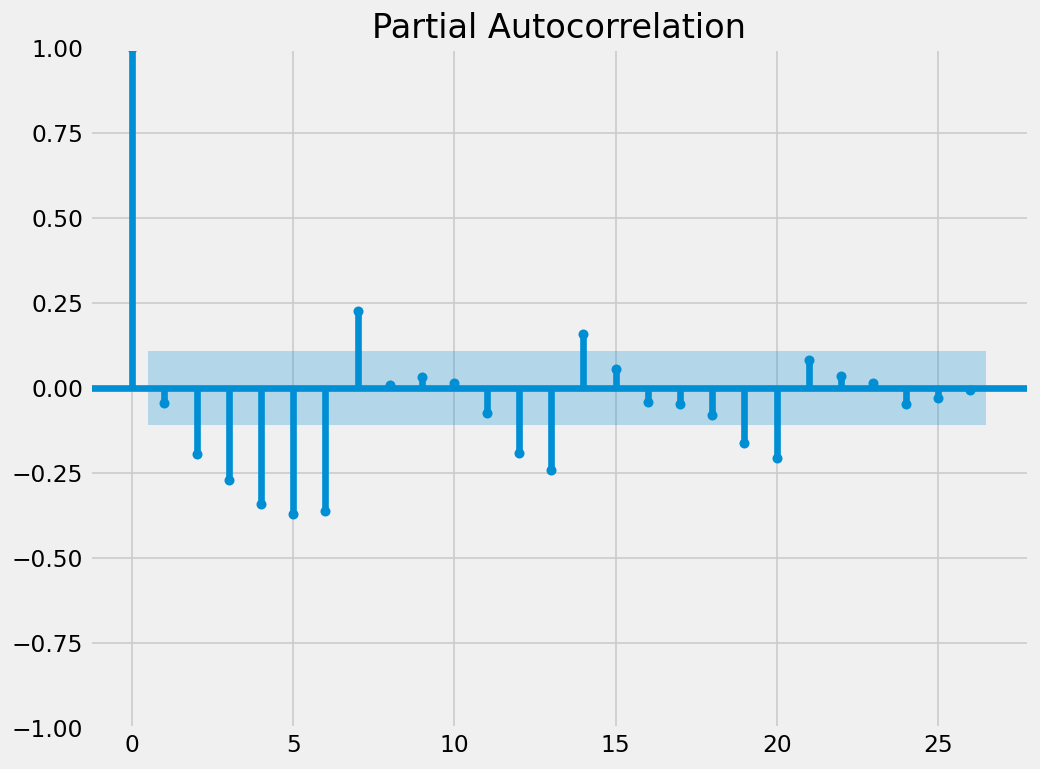

In [13]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data.Views.diff().dropna())

In [14]:
# Để tìm ra giá trị của q, chúng ta có thể sử dụng đồ thị ACF. 
# Điều này sẽ cho chúng ta biết cần có bao nhiêu đường trung bình động 
# để loại bỏ tự tương quan khỏi chuỗi thời gian cố định.

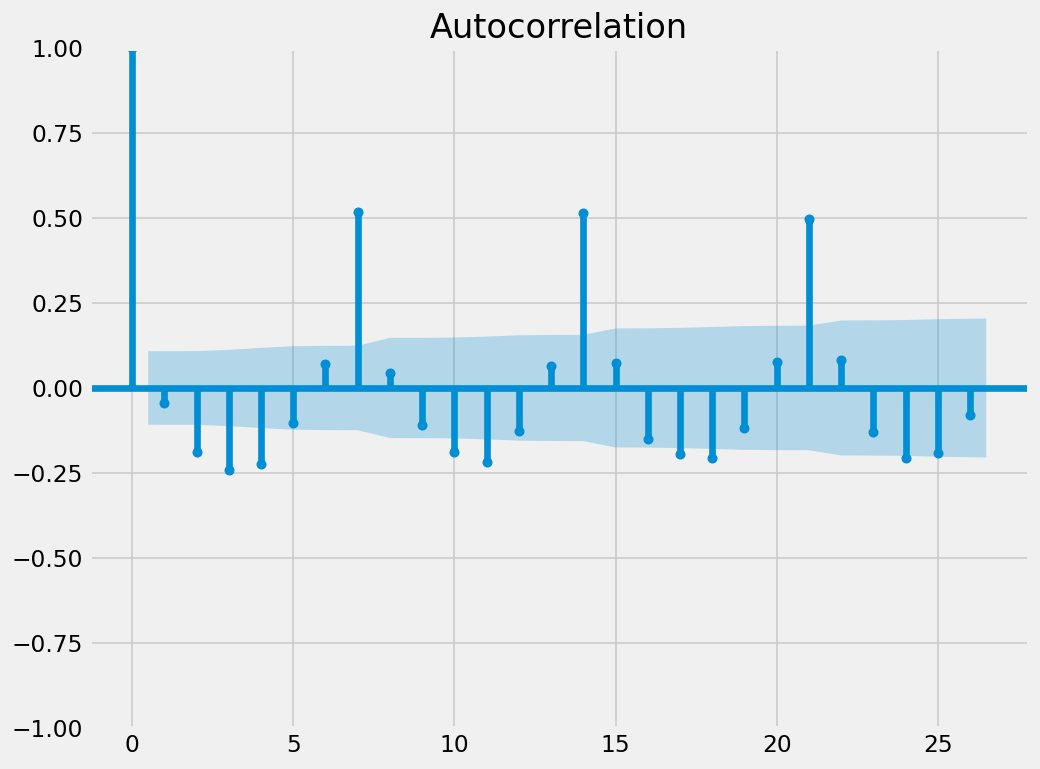

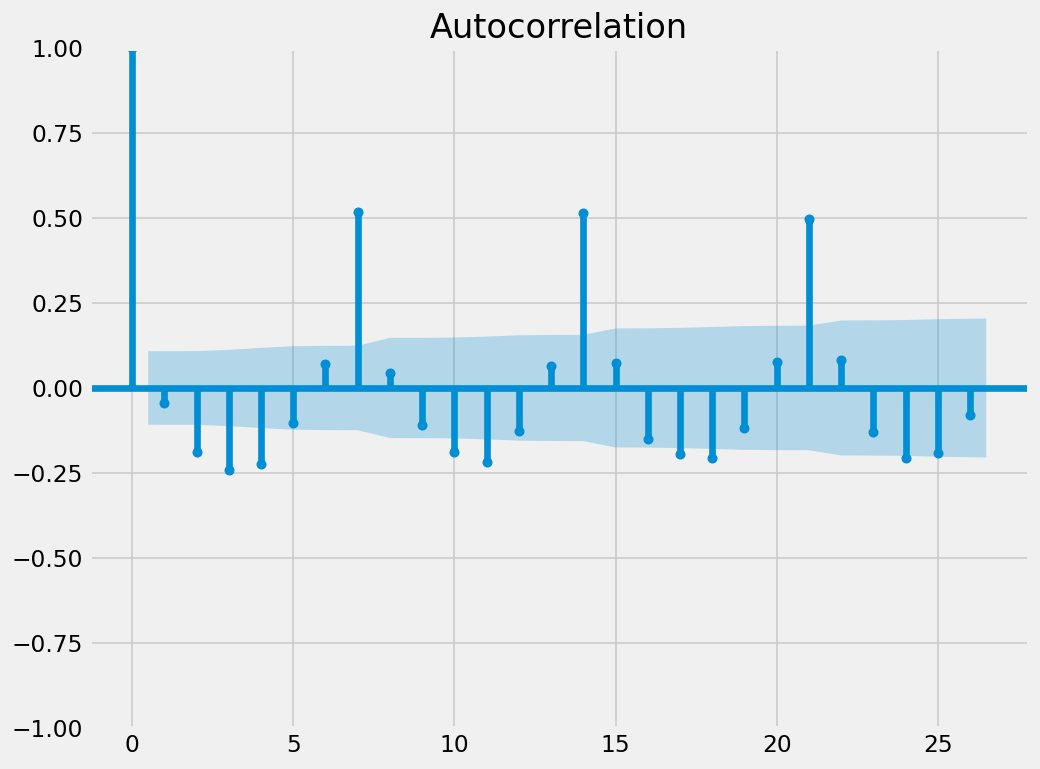

In [15]:
plot_acf(data.Views.diff().dropna())

In [16]:
# Đào tạo mô hình SARIMA cho nhiệm vụ dự báo lưu lượng truy cập trang web:
# p là chuỗi tự hồi qui AR (auto regression)
# q là chuỗi trung bình trượt MA (moving average)

p, d, q = 5, 1, 2
model=sm.tsa.statespace.SARIMAX(data['Views'],
                                order=(p, d, q),
                                seasonal_order=(p, d, q, 12))
model=model.fit()
print(model.summary())

C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                              Views   No. Observations:                  330
Model:             SARIMAX(5, 1, 2)x(5, 1, 2, 12)   Log Likelihood               -2604.244
Date:                            Fri, 20 Jan 2023   AIC                           5238.488
Time:                                    16:01:06   BIC                           5294.871
Sample:                                         0   HQIC                          5261.010
                                            - 330                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6643      0.166      3.991      0.000       0.338       0.991
ar.L2         -0.6937      0.137   

In [17]:
#Dự báo lưu lượng truy cập trên trang web trong 50 ngày tới.
predictions = model.predict(len(data), len(data) + 50)
print(predictions)

330    10518.750241
331     9914.411737
332     8762.489117
333     8418.741823
334     9439.819324
335    10693.788483
336    10972.408488
337    10852.201993
338     9706.551604
339     9080.317232
340     8607.950606
341     9519.516473
342    10881.836353
343    11381.378968
344    10660.117072
345    10007.559054
346     9358.993661
347     9507.620205
348     9707.143750
349    10858.975665
350    10871.063837
351    11036.832930
352    10084.428944
353     9547.748904
354     9565.550384
355     9915.020749
356    10793.780938
357    11036.890841
358    10812.410291
359    10258.036506
360     9385.204906
361     9647.915267
362     9843.384060
363    10736.517961
364    10885.274717
365    10966.575302
366    10572.871411
367     9859.656428
368     9677.410197
369    10098.356400
370    10854.847298
371    11320.093202
372    10859.711505
373    10558.435288
374     9747.451884
375     9767.312757
376     9947.424174
377    10772.333381
378    11396.630322
379    11288.442237


<AxesSubplot:>

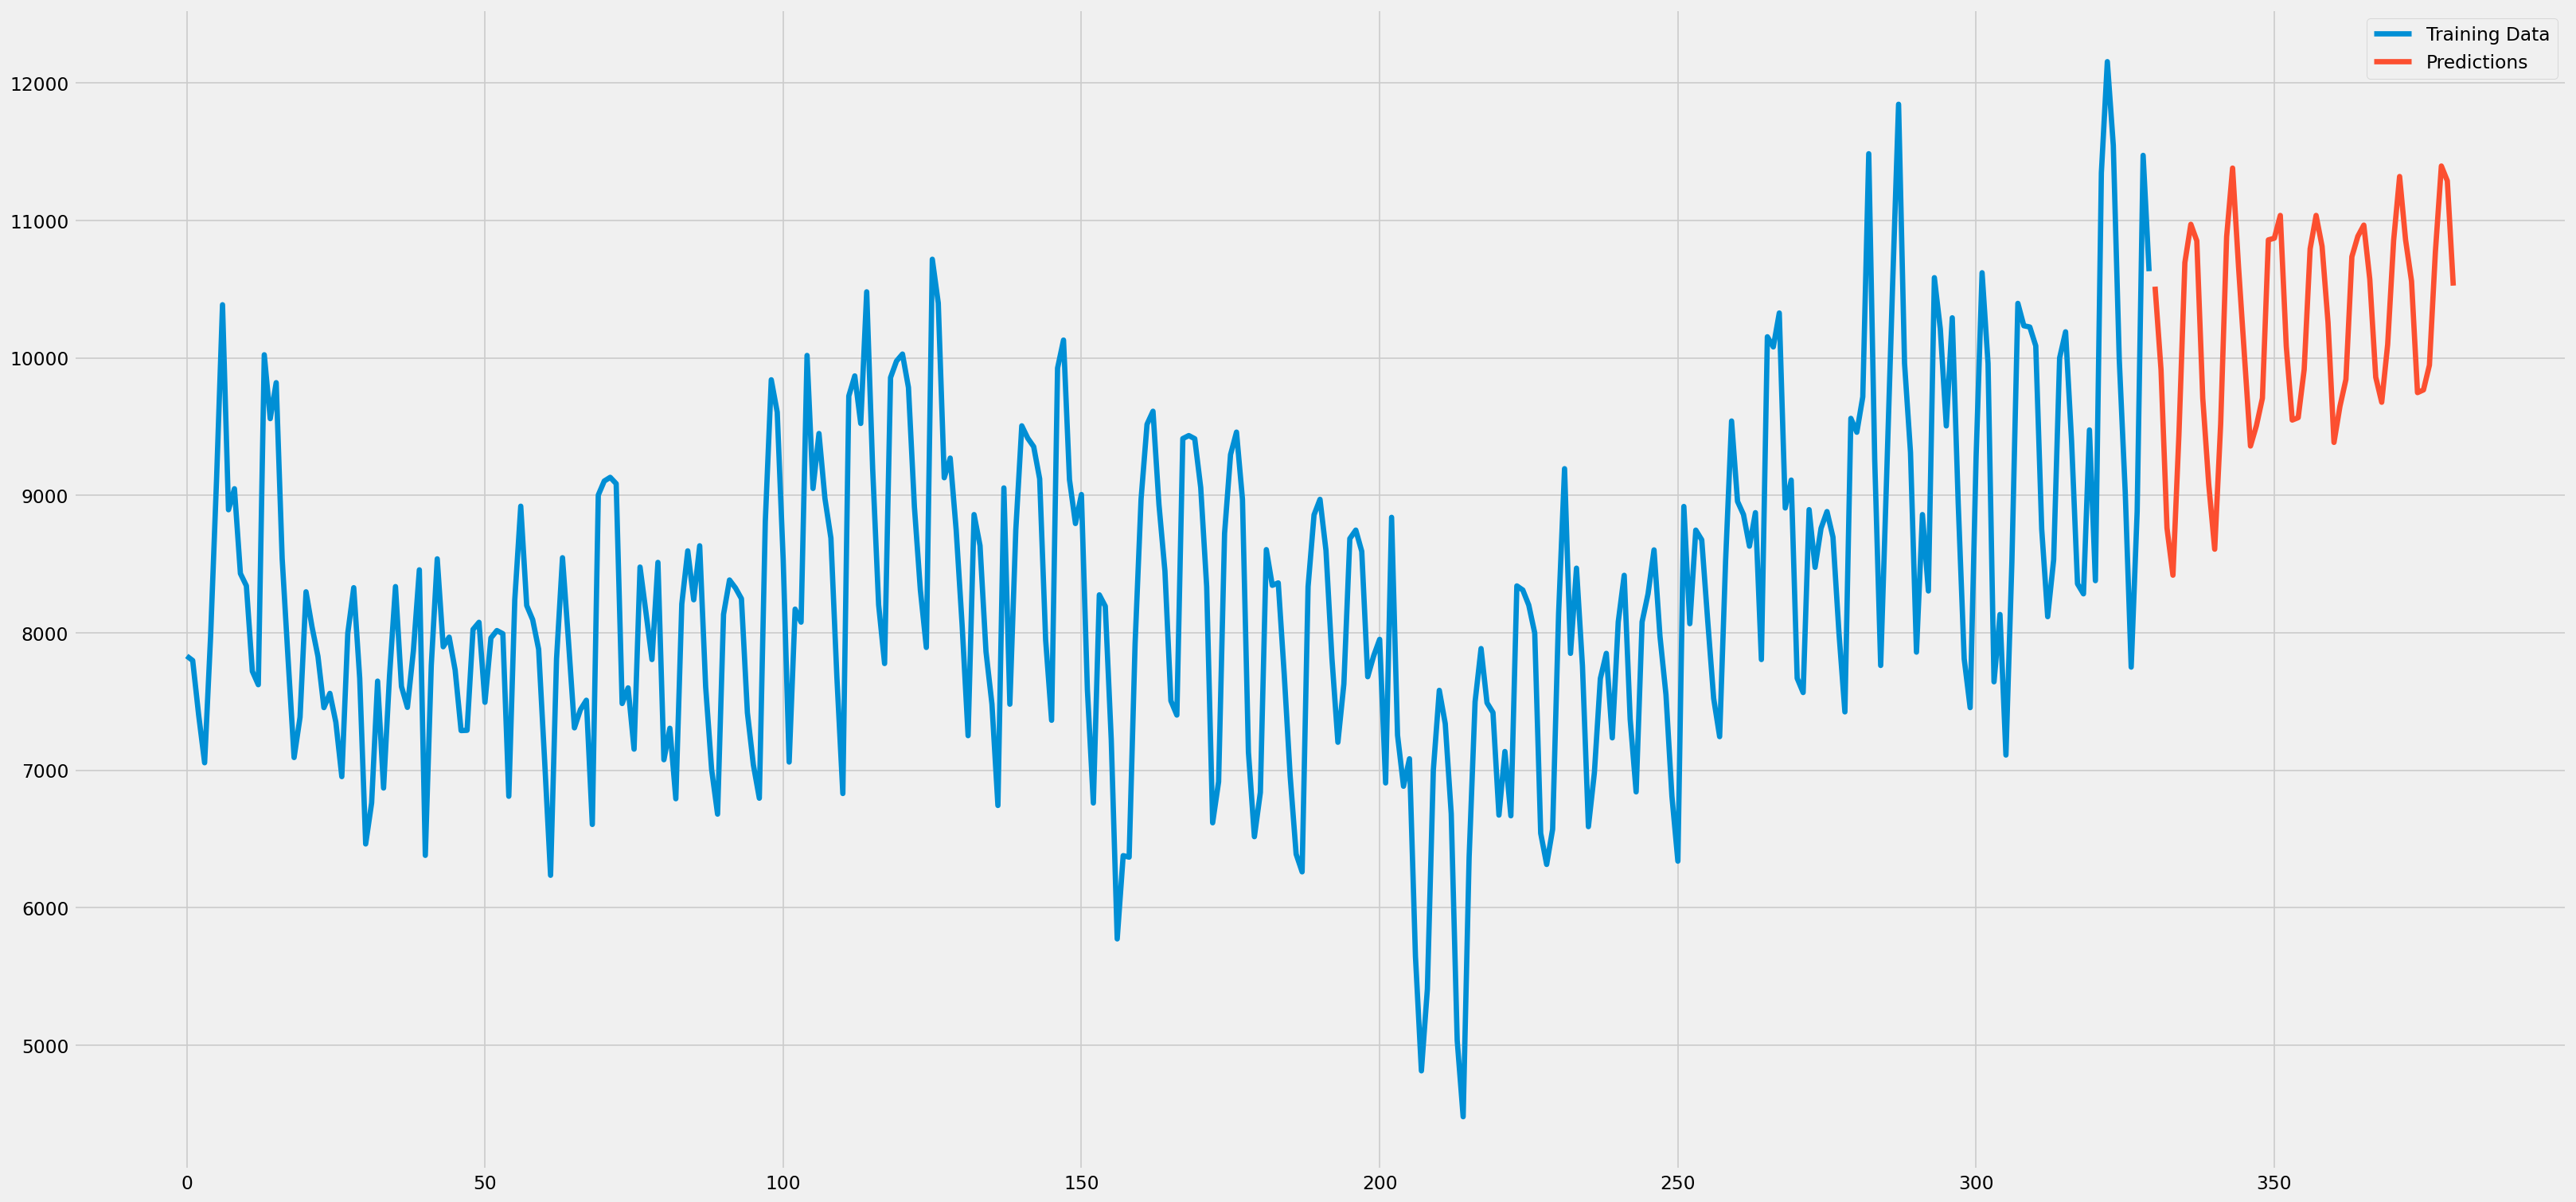

In [18]:
#Dữ liệu được dùng để training
data["Views"].plot(legend=True, label="Training Data", 
                   figsize=(30, 15))

#Xuất ra lưu lượng truy cập trên trang web trong 50 ngày tới
predictions.plot(legend=True, label="Predictions")